# Train all Models

(17270, 32)
(4702, 32)
(17270,)
(4702,)

Logistic Regression:
Accuracy: 0.5570
Precision: 0.5586
Recall: 0.7391
F1 Score: 0.6363

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.36      0.43      2237
           1       0.56      0.74      0.64      2465

    accuracy                           0.56      4702
   macro avg       0.56      0.55      0.53      4702
weighted avg       0.56      0.56      0.54      4702


Xgboost:
Accuracy: 0.5274
Precision: 0.5425
Recall: 0.6296
F1 Score: 0.5828

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.41      0.46      2237
           1       0.54      0.63      0.58      2465

    accuracy                           0.53      4702
   macro avg       0.52      0.52      0.52      4702
weighted avg       0.52      0.53      0.52      4702


Gradient Boosting:
Accuracy: 0.5523
Precision: 0.5569
Recall: 0.7152
F1 Score: 0.6262

Clas

/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)



TabNet:
Accuracy: 0.5555
Precision: 0.5584
Recall: 0.7274
F1 Score: 0.6318

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.37      0.44      2237
           1       0.56      0.73      0.63      2465

    accuracy                           0.56      4702
   macro avg       0.55      0.55      0.54      4702
weighted avg       0.55      0.56      0.54      4702



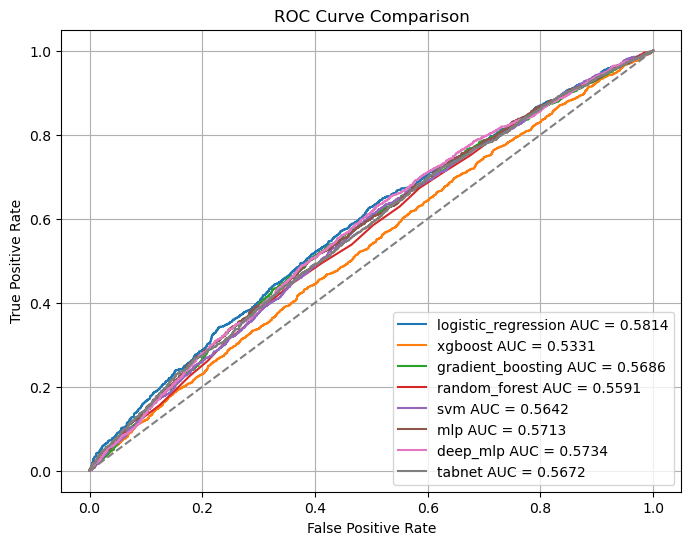


Model AUC Rankings:
logistic_regression: 0.5814
deep_mlp: 0.5734
mlp: 0.5713
gradient_boosting: 0.5686
tabnet: 0.5672
svm: 0.5642
random_forest: 0.5591
xgboost: 0.5331


In [1]:
import sqlite3
import json
import re
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    HAS_TABNET = True
except ImportError:
    HAS_TABNET = False
    print("Run pip install pytorch-tabnet")
    
# change this to either diff or raw
feature_method = "diff"

# Tanay's chdir
os.chdir("/Users/admin/Purdue + CS/MLB-AI-Betting/src/modelDevelopment")

# Will's change dir
#os.chdir('/home/stevenwh/Desktop/MLB-Game-Prediction/src/modelDevelopment')

from utils.featureExtraction import buildFeatures

# AUC tracking
auc_scores = {}
roc_curves = {}

# Connect to database
conn = sqlite3.connect("../../databases/MLB_Betting.db")

# Load data from SQL
join_query = """
SELECT 
    Features.game_id,
    OldGames.season,
    Features.features_json
FROM 
    Features
INNER JOIN 
    OldGames ON Features.game_id = OldGames.game_id
"""
df = pd.read_sql_query(join_query, conn)
df["features_json"] = df["features_json"].apply(json.loads)
df["season"] = df["season"].astype(int)

# Extract features
X_all, y_all, feature_names = buildFeatures(df, method=feature_method)
X_all = pd.concat([df[["game_id", "season"]], X_all], axis=1)
X_all["label"] = y_all

# Train/test split
df_train = X_all[X_all["season"] <= 2022]
df_test = X_all[X_all["season"] >= 2023]

X_train = df_train[feature_names]
X_test = df_test[feature_names]
Y_train = df_train["label"]
Y_test = df_test["label"]

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

# Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model file directory
os.makedirs("training", exist_ok=True)

# Save scaler and feature names
with open(f"training/model_files/scaler_{feature_method}.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open(f"training/model_files/feature_names_{feature_method}.pkl", "wb") as f:
    pickle.dump(feature_names, f)

# Save raw versions for non-scaled models
with open(f"training/model_files/X_train_{feature_method}.pkl", "wb") as f:
    pickle.dump(X_train, f)
with open(f"training/model_files/X_test_{feature_method}.pkl", "wb") as f:
    pickle.dump(X_test, f)

def print_metrics(name, y_true, y_pred):
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Model dictionary
model_configs = {
    "logistic_regression": (LogisticRegression(max_iter=1000), True),
    "xgboost": (XGBClassifier(eval_metric='logloss'), False),
    "gradient_boosting": (HistGradientBoostingClassifier(max_iter=200, random_state=42), True),
    "random_forest": (RandomForestClassifier(n_estimators=100, random_state=42), True),
    "svm": (SVC(kernel='rbf', probability=True), True)
}

for name, (model, use_scaling) in model_configs.items():
    model.fit(X_train_scaled if use_scaling else X_train, Y_train)
    y_pred = model.predict(X_test_scaled if use_scaling else X_test)
    y_proba = model.predict_proba(X_test_scaled if use_scaling else X_test)[:, 1]
    print_metrics(name.replace('_', ' ').title(), Y_test, y_pred)
    roc_auc = roc_auc_score(Y_test, y_proba)
    fpr, tpr, _ = roc_curve(Y_test, y_proba)
    roc_curves[name] = (fpr, tpr)
    auc_scores[name] = roc_auc
    with open(f"training/model_files/{name}_model_{feature_method}.pkl", "wb") as f:
        pickle.dump(model, f)

# TODO: if you drop more features, this needs to change? make it not hard coded
# MLP
# class MLP(nn.Module):
#     def __init__(self, input_size):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, 64)
#         self.fc2 = nn.Linear(64, 2)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         return self.fc2(x)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        # scale with input features
        hidden_size = max(32, input_size // 2) 
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

mlp_model = MLP(X_train_scaled.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(Y_train.values, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

mlp_model.train()
# TODO: change number of iterations
for epoch in range(10):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = mlp_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(torch.tensor(X_test_scaled, dtype=torch.float32))
    y_pred = logits.argmax(dim=1).numpy()
    y_proba = torch.softmax(logits, dim=1)[:, 1].numpy()
print_metrics("MLP", Y_test, y_pred)
roc_auc = roc_auc_score(Y_test, y_proba)
fpr, tpr, _ = roc_curve(Y_test, y_proba)
roc_curves["mlp"] = (fpr, tpr)
auc_scores["mlp"] = roc_auc

torch.save(mlp_model.state_dict(), f"training/model_files/mlp_model_{feature_method}.pt")

# TODO: Change this
# Deep MLP with Dropout
# class DeepMLP(nn.Module):
#     def __init__(self, input_size):
#         super(DeepMLP, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_size, 128),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(64, 2)
#         )

#     def forward(self, x):
#         return self.model(x)

class DeepMLP(nn.Module):
    def __init__(self, input_size):
        super(DeepMLP, self).__init__()
        hidden1 = max(64, input_size * 2)
        hidden2 = max(32, input_size)
        
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden2, 2)
        )
        
    def forward(self, x):
        return self.model(x)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

deep_mlp = DeepMLP(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deep_mlp.parameters(), lr=0.001)

# TODO change number of iterations for training
for epoch in range(20):
    deep_mlp.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = deep_mlp(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

deep_mlp.eval()
with torch.no_grad():
    logits = deep_mlp(X_test_tensor)
    y_pred = torch.argmax(logits, dim=1).numpy()
    y_proba = torch.softmax(logits, dim=1)[:, 1].numpy()
print_metrics("Deep MLP", Y_test, y_pred)
roc_auc = roc_auc_score(Y_test, y_proba)
fpr, tpr, _ = roc_curve(Y_test, y_proba)
roc_curves["deep_mlp"] = (fpr, tpr)
auc_scores["deep_mlp"] = roc_auc

torch.save(deep_mlp.state_dict(), f"training/model_files/deep_mlp_model_{feature_method}.pt")

# TabNet
if HAS_TABNET:
    tabnet = TabNetClassifier(verbose=0)
    tabnet.fit(X_train.values, Y_train.values)
    y_pred = tabnet.predict(X_test.values)
    y_proba = tabnet.predict_proba(X_test.values)[:, 1]
    print_metrics("TabNet", Y_test, y_pred)
    roc_auc = roc_auc_score(Y_test, y_proba)
    fpr, tpr, _ = roc_curve(Y_test, y_proba)
    roc_curves["tabnet"] = (fpr, tpr)
    auc_scores["tabnet"] = roc_auc

    with open(f"training/model_files/tabnet_model_{feature_method}.pkl", "wb") as f:
        pickle.dump(tabnet, f)

# Plot all models
plt.figure(figsize=(8, 6))
for model_name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model_name} AUC = {auc_scores[model_name]:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# AUC Ranking
print("\nModel AUC Rankings:")
for model, score in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {score:.4f}")

# Evaluating all Models

In [4]:
import sqlite3
import pandas as pd
import os
import json
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re
import pickle

# Tanay's directory
os.chdir("/Users/admin/Purdue + CS/MLB-AI-Betting/src/modelDevelopment")

# Will's directory
# os.chdir('/home/stevenwh/Desktop/MLB-Game-Prediction/src/modelDevelopment')

from evaluating.testOnCurrentSeason import main_evaluate

feature_method = "diff"

for model in ["logistic_regression", "gradient_boosting", "random_forest", "svm", "xgboost", "mlp", "deep_mlp", "tabnet"]:
    main_evaluate(model, feature_method)
    print(f"Finished {model}")

Finished logistic_regression
Finished gradient_boosting
Finished random_forest
Finished svm
Finished xgboost
Finished mlp
Finished deep_mlp
Finished tabnet


# Print Results

### Raw method

In [5]:
for model in ["logistic_regression", "gradient_boosting", "random_forest", "svm", "xgboost", "mlp", "deep_mlp", "tabnet"]:
    with open(f"evaluation_logs/testingOnCurrentSeason_{model}_raw.log", "r") as f:
        last_lines = f.readlines()[-9:]
        for line in last_lines:
            print(line.strip())
        print()


FINAL STATS
Model: logistic_regression
Feature Method: raw
Total Bets Placed: 1155
Amount Wagered: 544.46 units
Skipped Games: 351
Total Profit: 4.45 units
Hit Rate: 49.09%
ROI: 0.82%

FINAL STATS
Model: gradient_boosting
Feature Method: raw
Total Bets Placed: 1245
Amount Wagered: 727.98 units
Skipped Games: 261
Total Profit: -35.32 units
Hit Rate: 46.27%
ROI: -4.85%

FINAL STATS
Model: random_forest
Feature Method: raw
Total Bets Placed: 1262
Amount Wagered: 787.49 units
Skipped Games: 244
Total Profit: -39.96 units
Hit Rate: 46.04%
ROI: -5.07%

FINAL STATS
Model: svm
Feature Method: raw
Total Bets Placed: 1215
Amount Wagered: 600.66 units
Skipped Games: 291
Total Profit: -12.17 units
Hit Rate: 46.17%
ROI: -2.03%

FINAL STATS
Model: xgboost
Feature Method: raw
Total Bets Placed: 1397
Amount Wagered: 2164.99 units
Skipped Games: 109
Total Profit: -72.52 units
Hit Rate: 48.39%
ROI: -3.35%

FINAL STATS
Model: mlp
Feature Method: raw
Total Bets Placed: 1217
Amount Wagered: 711.73 units
Sk

### Diff method

In [5]:
for model in ["logistic_regression", "gradient_boosting", "random_forest", "svm", "xgboost", "mlp", "deep_mlp", "tabnet"]:
    with open(f"evaluation_logs/testingOnCurrentSeason_{model}_diff.log", "r") as f:
        last_lines = f.readlines()[-9:]
        for line in last_lines:
            print(line.strip())
            
        print()


FINAL STATS
Model: logistic_regression
Feature Method: diff
Total Bets Placed: 1161
Amount Wagered: 508.45 units
Skipped Games: 345
Total Profit: 0.91 units
Hit Rate: 48.49%
ROI: 0.18%

FINAL STATS
Model: gradient_boosting
Feature Method: diff
Total Bets Placed: 1190
Amount Wagered: 614.08 units
Skipped Games: 316
Total Profit: -18.51 units
Hit Rate: 46.55%
ROI: -3.01%

FINAL STATS
Model: random_forest
Feature Method: diff
Total Bets Placed: 1232
Amount Wagered: 790.27 units
Skipped Games: 274
Total Profit: -40.80 units
Hit Rate: 46.51%
ROI: -5.16%

FINAL STATS
Model: svm
Feature Method: diff
Total Bets Placed: 1214
Amount Wagered: 586.94 units
Skipped Games: 292
Total Profit: -7.08 units
Hit Rate: 46.21%
ROI: -1.21%

FINAL STATS
Model: xgboost
Feature Method: diff
Total Bets Placed: 1387
Amount Wagered: 1973.73 units
Skipped Games: 119
Total Profit: 86.21 units
Hit Rate: 51.91%
ROI: 4.37%

FINAL STATS
Model: mlp
Feature Method: diff
Total Bets Placed: 1153
Amount Wagered: 591.83 units

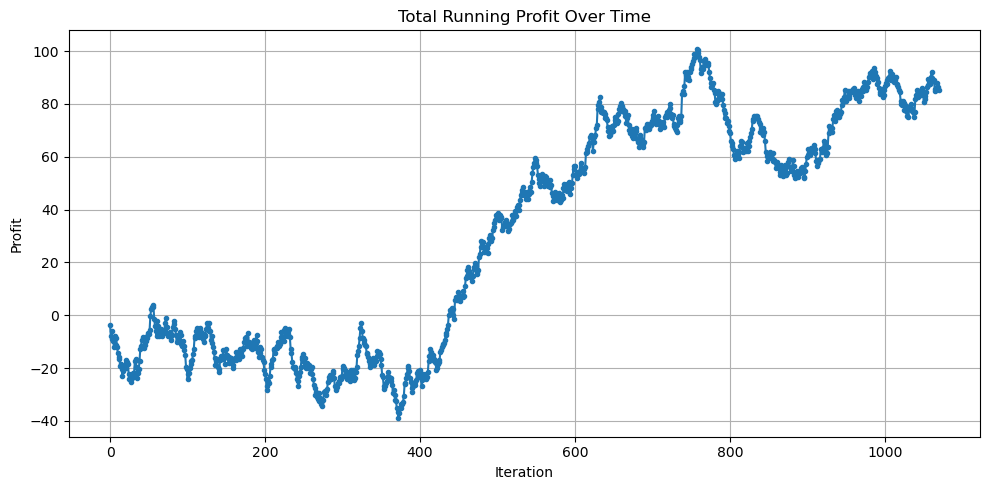

In [9]:
import re
import matplotlib.pyplot as plt

profit_values = []

with open("evaluation_logs/testingOnCurrentSeason_xgboost_diff.log", "r") as f:
    for line in f:
        match = re.search(r"total running profit is ([\-0-9.]+)", line)
        if match:
            profit = float(match.group(1))
            profit_values.append(profit)

plt.figure(figsize=(10, 5))
plt.plot(profit_values, marker='.')
plt.title("Total Running Profit Over Time")
plt.xlabel("Iteration")
plt.ylabel("Profit")
plt.grid(True)
plt.tight_layout()
plt.show()
